In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
df = pd.read_csv("../data/fish_data_after_depth.csv")
df

name  Length  image_height  image_width  \
0    003CF0C48BE2DFF5C1258437005E7AEC.jpg      74           800          600   
1    0092fde593df4d309f284b5e911f2339.jpg      96           800          600   
2    00a23139199c468b93ad0d8ce53f9e36.jpg      97           600          800   
3    00F9A7C9C7EA82A6C12589930064A952.jpg      91           600          800   
4    017ABDE8EC03166FC12585F70031A308.jpg      56           800          600   
..                                    ...     ...           ...          ...   
648  FD5E876CE1694C5BC12589BE00377336.jpg      72           800          600   
649  fdb0350426e841edb8515ed0578b451b.jpg      85           800          600   
650  FDEEDCB0F83DC715C125885A005EF07B.jpg      92           600          800   
651  FDF55677CD46C2DEC125876500708FC7.jpg      65           450          800   
652  FE1AABDD16A3B115C12588D700276643.jpg      80           450          800   

     head_x1  head_y1  head_x2  head_y2  head_x_center  head_y_center  ...  \
0     563.41   402.28   600.00   516.31         581.71         459.29  ...   
1     512.71   356.17   600.00   458.77         556.36         407.47  ...   
2     565.31   412.82   683.14   511.29         624.23         462.06  ...   
3     429.21   249.74   501.85   321.35         465.53         285.54  ...   
4     414.62   437.19   476.59   490.57         445.60         463.88  ...   
..       ...      ...      ...      ...            ...            ...  ...   
648   432.91   313.17   584.82   426.17         508.86         369.67  ...   
649   506.38   356.62   600.00   451.73         553.19         404.18  ...   
650   479.14   293.90   566.92   352.52         523.03         323.21  ...   
651   587.93   273.88   727.22   364.78         657.57         319.33  ...   
652   599.62   174.46   701.64   252.22         650.63         213.34  ...   

     tail_width  tail_height  tail_width_scaled  tail_height_scaled  \
0         44.30       109.32               0.07                0.14   
1         48.03       115.90               0.08                0.14   
2         98.99       124.23               0.12                0.21   
3         68.16       103.29               0.09                0.17   
4         69.18        57.92               0.12                0.07   
..          ...          ...                ...                 ...   
648       28.39        95.57               0.05                0.12   
649       90.79       104.99               0.15                0.13   
650       73.23        89.34               0.09                0.15   
651      107.31       131.70               0.13                0.29   
652       71.52        76.08               0.09                0.17   

     focal_length  depth_min     depth_max  depth_head_center  \
0       911.51870   0.597505      1.844256           1.184180   
1      1719.84610   1.504191  10000.000000           1.748690   
2      2419.86250   0.980434      2.161522           1.007893   
3       724.17770   0.615626      1.041435           0.617078   
4       867.18870   0.935140      1.338400           1.019175   
..            ...        ...           ...                ...   
648     860.07110   0.742539      2.439703           1.253008   
649     950.13135   0.577314      4.546573           1.364727   
650     843.83405   0.679467      2.694058           0.868767   
651     781.46655   0.557743      1.668428           0.899759   
652     767.44110   0.314675      0.444219           0.342030   

     depth_body_center  depth_tail_center  
0             1.211296           1.258488  
1             1.766344           1.671811  
2             1.088727           1.191137  
3             0.631572           0.654825  
4             0.994171           0.998941  
..                 ...                ...  
648           1.237043           1.349383  
649           1.399679           1.497410  
650           0.901010           0.963750  
651           0.996378           1.131094  
652           0.33227

In [6]:
X, y = df.drop(columns=["name", "Length"]), df["Length"]

MAPE: 12.78


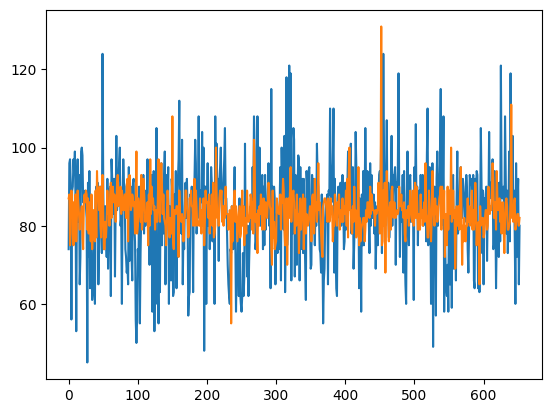

In [7]:
pred = cross_val_predict(LinearRegression(fit_intercept=False), X, y).round().astype(int)
print("MAPE:", (mean_absolute_percentage_error(y, pred) * 100).round(2))

plt.plot(y)
plt.plot(pred)
plt.show()

In [16]:
df["Predictions"] = pred
df["Loss"] = round(np.abs((y-pred)/y) * 100, 2)
df.to_csv("../data/fish_data_after_length.csv", index=False)

In [14]:
df["Loss"]

0      14.94
1       9.09
2      29.33
3      16.67
4      37.08
       ...  
648    12.20
649     2.41
650    10.84
651    18.75
652     2.44
Name: Loss, Length: 653, dtype: float64

In [45]:
# Datalaoder
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [46]:
# MLP
class MLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [47]:
X, y = df.drop(columns=["name", "Length"]), df["Length"]
train_dataset = MyDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 100

model = MLP(X.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    model.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

/students/Hasan/fishometry/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/students/Hasan/fishometry/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss: 187.99366760253906
Epoch 51/100, Loss: 118.29375457763672


In [55]:
pred, real = [], []
for X, y in train_loader:
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    pred.extend(y_pred.cpu().detach().numpy())
    real.extend(y.cpu().detach().numpy())
pred, real = np.ravel(pred), np.ravel(real)
print("MAPE:", (mean_absolute_percentage_error(real, pred) * 100).round(2))


MAPE: 13.59


MAPE: 13.592129945755005


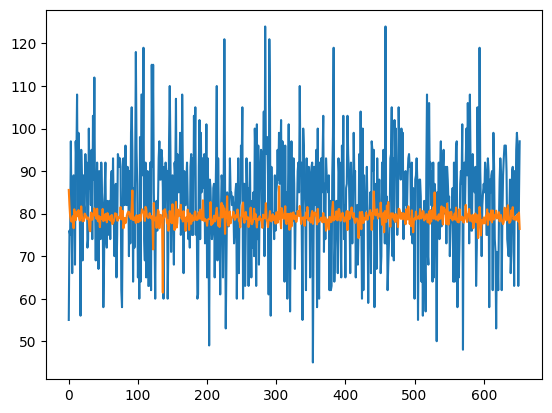

In [56]:
print("MAPE:", mean_absolute_percentage_error(real, pred) * 100)
plt.plot(real)
plt.plot(pred)
plt.show()